# Import packages

In [1263]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score


variables à garder : 
['fam_ENQ', 'fl_fam_vam', 'niv_gravite_mtf_dne', 'fam_PCD',
       'Motif_Motif moyen', 'Motif_Motif tres mauvais',
       'Situation_fam_Mauvaise situation', 'Nature_op_Mauvaise nature']

# Import data

In [1264]:
df = pd.read_csv('../data/df.csv',sep = ',')

In [1265]:
df.columns

Index(['cd_op', 'MT_CHG_MSL', 'MT_PATRIM_NET', 'EAD_1an_avant_def', 'TX_APPOR',
       'dat_dec_echec', 'ANC_PRO_MAX_PFI', 'arrete', 'MT_EAD_RESID',
       'FL_REL_NON_ANNULE', 'nb_bienHOP', 'cum_frs_externes',
       'dls_mep_entree_def', 'NB_LO_HOP', 'MT_CHA_CSM_REV',
       'CD_DNE_CHR_LGD_SAIN', 'MT_EAD_DNE_CHR_d', 'mt_rev_dispo',
       'MT_REST_VIVRE', 'MR_arr', 'NB_DUR_PFI', 'fl_fonc', 'AMI', 'solution',
       'AGE_EMP1', 'date_entree_defaut', 'NB_CHARGE_HORS_OPE_PFI', 'cum_dec',
       'MT_CHA_IMP', 'max_age_ctx', 'MT_CHA_PIV', 'MT_CHA_PIP', 'TX_ENDET',
       'cum_rec', 'nb_empr_ope', 'PTG', 'MT_PATRIM_MOB', 'fam_PCD',
       'NB_RP_HOP', 'fl_prise_de_gar', 'dls_ges_def', 'nb_prt',
       'mt_dec_cum_IMP_tot', 'fl_prt_Conso', 'niv_gravite_mtf_dfs',
       'DT_MEP_OPE', 'MT_FMG', 'CD_POST_BIEN_PFI', 'MT_CHA_HORS_OPE_PFI',
       'ANC_BANC_MAX_PFI', 'MT_REV_PFI', 'DET', 'Motif', 'Situation_fam',
       'Nature', 'Solution_echec', 'Nature_op', 'MTF', 'ETAT_CIVIL', 'CSP',
       

In [1266]:
#df = df[['mt_dec_cum_IMP_tot','cd_op','arrete','DET']]

In [1267]:
#df.drop(columns = ['MT_EAD_RESID', 'fl_prise_de_gar', 'fam_hyp', 'PTG'])

In [1268]:
df.head()

,cd_op,MT_CHG_MSL,MT_PATRIM_NET,EAD_1an_avant_def,TX_APPOR,dat_dec_echec,ANC_PRO_MAX_PFI,arrete,MT_EAD_RESID,FL_REL_NON_ANNULE,...,DET,Motif,Situation_fam,Nature,Solution_echec,Nature_op,MTF,ETAT_CIVIL,CSP,ANC_PRO_MAX_PFI_2
0,I860708600,304.90,0.0,1121.38,0.00,0,84.0,2017-01-31,-3945.79,0,...,0,Motif mauvais,Bonne situation,Bonne nature,Bonne solution,Bonne nature,Bon MTF,Mauvais etat,Bonne CSP,0.036025
1,I950404213,2505.35,0.0,2475.00,0.10,0,203.0,2017-03-31,0.03,0,...,0,Motif mauvais,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Mauvaise CSP,0.194694
2,I950706618,0.00,45735.0,870.00,0.07,0,42.0,2016-08-31,1078.86,0,...,1,Motif moyen,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Bonne CSP,-0.061161
3,I950901248,0.00,0.0,525.06,0.44,0,166.0,2017-01-31,525.06,0,...,0,Motif moyen,Mauvaise situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Mauvais etat,Mauvaise CSP,0.194694
4,I960300578,0.00,0.0,815.46,0.47,0,3.0,2016-06-30,5835.03,0,...,0,Motif mauvais,Bonne situation,Mauvaise nature,Bonne solution,Mauvaise nature,Mauvais MTF,Bon etat,Mauvaise CSP,-0.228634


# Data treatment

In [1269]:
df['arrete'] = pd.to_datetime(df['arrete'])

# Encoding

In [1270]:
df_obj = df.select_dtypes(include ='object')

In [1271]:
df_obj.columns

Index(['cd_op', 'date_entree_defaut', 'nb_empr_ope', 'Motif', 'Situation_fam',
       'Nature', 'Solution_echec', 'Nature_op', 'MTF', 'ETAT_CIVIL', 'CSP'],
      dtype='object')

In [1272]:
df['Motif'] = df['Motif'].apply(lambda x : 3 if x == 'Motif tres mauvais' else 2 if x == 'Motif mauvais' else 1)

df['Situation_fam'] = df['Situation_fam'].apply(lambda x : 2 if x == 'Mauvaise situation' else 1)

df['Nature'] = df['Nature'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['Solution_echec'] = df['Solution_echec'].apply(lambda x : 2 if x == 'Mauvaise solution' else 1)

df['Nature_op'] = df['Nature_op'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['MTF'] = df['MTF'].apply(lambda x : 2 if x == 'Mauvais MTF' else 1)

df['ETAT_CIVIL'] = df['ETAT_CIVIL'].apply(lambda x : 2 if x == 'Mauvais etat' else 1)

df['CSP'] = df['CSP'].apply(lambda x : 2 if x == 'Mauvaise CSP' else 1)

df['nb_empr_ope'] = df['nb_empr_ope'].apply(lambda x : 1 if x == 'Un emprunteur' else 2)

In [1273]:
df = df[['Motif', 'niv_gravite_mtf_dfs', 'MTF',
       'ANC_PRO_MAX_PFI_2', 'nb_empr_ope', 'CD_DNE_CHR_LGD_SAIN', 'MT_EAD_RESID', 'fam_PCD','mt_dec_cum_IMP_tot',
       'cum_dec', 'MT_REST_VIVRE', 'DET', 'arrete', 'cd_op']]


# 01-Logit simple

In [1274]:
df_validation = df[df['arrete']>"2020-06-30"]

data = df[df['arrete']<"2019-12-31"]

In [1275]:
data['DET'].value_counts()

DET
0    8936
1    5414
Name: count, dtype: int64

In [1276]:
# Sélectionner les données
X_train = data.copy() # On drop les var qui ont trop de NaN
X_test = df_validation.copy()

X_train = X_train.select_dtypes(exclude = 'datetime')
X_train.dropna(inplace = True)

y_train = X_train['DET']


X_train.drop(columns = 'DET', inplace = True)

X_test = X_test.select_dtypes(exclude = 'datetime')
X_test.dropna(inplace = True)

y_test = X_test['DET']

X_test.drop(columns = 'DET', inplace = True)

Il faut drop une colonne par var cat pour eviter le probleme de multicolinearité

In [1277]:
X_train.columns

Index(['Motif', 'niv_gravite_mtf_dfs', 'MTF', 'ANC_PRO_MAX_PFI_2',
       'nb_empr_ope', 'CD_DNE_CHR_LGD_SAIN', 'MT_EAD_RESID', 'fam_PCD',
       'mt_dec_cum_IMP_tot', 'cum_dec', 'MT_REST_VIVRE', 'cd_op'],
      dtype='object')

In [1278]:
X_train.drop(columns = ['cd_op'], inplace = True)

X_test.drop(columns = ['cd_op'], inplace = True)

In [1279]:
model = LogisticRegression(penalty='l1', solver='liblinear')

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


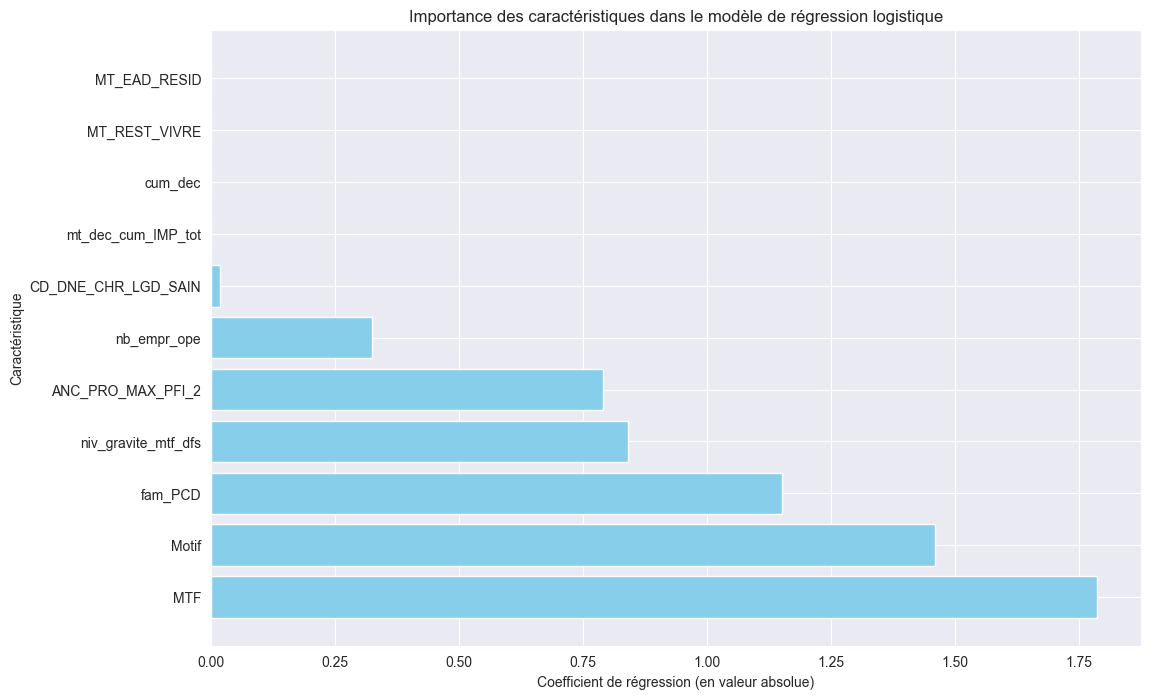

In [1280]:
coefficients = model.coef_[0]

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_importance_df['Abs_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Coefficient de régression (en valeur absolue)')
plt.ylabel('Caractéristique')
plt.title('Importance des caractéristiques dans le modèle de régression logistique')
plt.show()


In [1281]:
feature_importance_df

,Feature,Coefficient,Abs_Coefficient
2,MTF,1.785637e+00,1.785637e+00
0,Motif,1.459168e+00,1.459168e+00
7,fam_PCD,1.150482e+00,1.150482e+00
1,niv_gravite_mtf_dfs,8.415857e-01,8.415857e-01
3,ANC_PRO_MAX_PFI_2,-7.896616e-01,7.896616e-01
4,nb_empr_ope,-3.250455e-01,3.250455e-01
5,CD_DNE_CHR_LGD_SAIN,-1.751165e-02,1.751165e-02
8,mt_dec_cum_IMP_tot,4.942799e-05,4.942799e-05
9,cum_dec,-4.839505e-05,4.839505e-05
10,MT_REST_VIVRE,-4.232324e-06,4.232324e-06


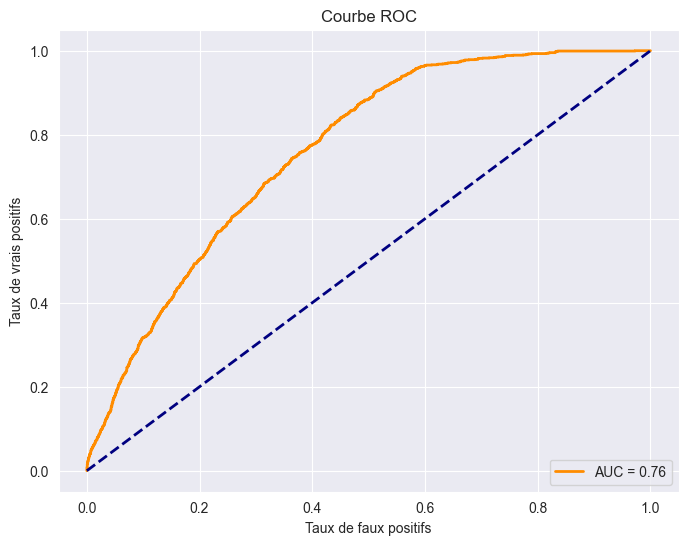

In [1282]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculer l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

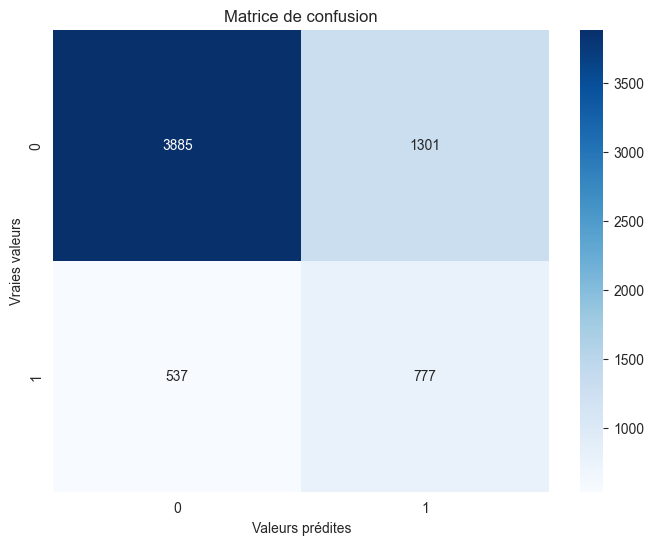

In [1283]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()
